# **ML Assignment 10**

By 23520011 - Sharaneshwar Punjal

Download the following dataset - https://www.kaggle.com/datasets/erdemtaha/cancer-data/data 

1. Drop `Id` column.

2. Use the `Diagnosis` column as the target with Classes B and M.

3. Perform a train-test split: 80% for training and 20% for testing.

4. Following manipulation is performed to increase the skew in the data (only for this assignment, not to be done in practice):
   - From train data:
      - Consider all rows with diagnosis label = M.
      - From these, randomly remove 120 rows with label M and append them to the test data.

5. Build 10 decision trees using:
   - Feature bagging: Use all features for each tree, but at each node split, randomly choose a subset of features using `max_features` in sklearn.
   - Sample bagging: If the train data size is N, train each tree using N samples selected with replacement.

6. Combine feature importance from all trees:
   - Either use simple average or a weighted average using tree accuracy as weight.
   - Feature importance can be fetched from `.feature_importances_` attribute or computed using `sklearn.inspection.permutation_importance`.

7. Shortlist the most important features based on the above step and drop the rest from training data.

8. Train 10 new decision trees using only the shortlisted features.

9. Build two models using inputs as:
   - Shortlisted features
   - Predictions from the 10 trees trained in step 8
      - Logistic Regression Model
      - Master Decision Tree

10. On test data:
   - Keep only the shortlisted features.
   - Predict using the 10 trees from step 8.
   - Combine these predictions with the shortlisted features and:
      - Predict using the logistic regression model.
      - Predict using the master decision tree.
   - Compare accuracies of both models and evaluate which gives better performance. Note how much improvement they offer over the original 10 trees.

11. Since the training data was made more skewed by reducing the minority class (M), use class weights while training. Also, while evaluating accuracy, pay special attention to recall of the minority class.

#### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, classification_report
import matplotlib.pyplot as plt

#### Loading and Viewing Data

In [3]:
df = pd.read_csv('Cancer_Data.csv')
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


#### Cleaning & Preparing Target

In [4]:
df = df.drop(columns=['id'])
df = df.drop(columns=['Unnamed: 32'])

# Separate features and target with binary mapping: 'B' → 0, 'M' → 1
X = df.drop('diagnosis', axis=1)
y = df['diagnosis'].map({'B': 0, 'M': 1})

#### Train-Test Split

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2 , random_state=42)

X_train.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
68,9.029,17.33,58.79,250.5,0.10660,0.14130,0.31300,0.04375,0.2111,0.08046,...,10.31,22.65,65.50,324.7,0.14820,0.43650,1.25200,0.17500,0.4228,0.11750
181,21.090,26.57,142.70,1311.0,0.11410,0.28320,0.24870,0.14960,0.2395,0.07398,...,26.68,33.48,176.50,2089.0,0.14910,0.75840,0.67800,0.29030,0.4098,0.12840
63,9.173,13.86,59.20,260.9,0.07721,0.08751,0.05988,0.02180,0.2341,0.06963,...,10.01,19.23,65.59,310.1,0.09836,0.16780,0.13970,0.05087,0.3282,0.08490
248,10.650,25.22,68.01,347.0,0.09657,0.07234,0.02379,0.01615,0.1897,0.06329,...,12.25,35.19,77.98,455.7,0.14990,0.13980,0.11250,0.06136,0.3409,0.08147
60,10.170,14.88,64.55,311.9,0.11340,0.08061,0.01084,0.01290,0.2743,0.06960,...,11.02,17.45,69.86,368.6,0.12750,0.09866,0.02168,0.02579,0.3557,0.08020


#### Making the Data More Challenging

To make things harder and simulate real-world data imbalance, we:
- Removed 120 malignant cases (M) from training set.
- Added those to the test set.

Now the training set has fewer malignant cases, making classification trickier. But this allows us to test how well models handle imbalance

In [6]:
# Combine X and y to filter together
train_data = X_train.copy()
train_data['Diagnosis'] = y_train

# Filter rows where Diagnosis == 1 (Malignant)
m_samples = train_data[train_data['Diagnosis'] == 1]

# Randomly select 120 rows with label 1 (Malignant)
m_selected = m_samples.sample(n=120, random_state=42)

# Drop these rows from training data
train_data = train_data.drop(m_selected.index)

# Prepare test data
test_data = X_test.copy()
test_data['Diagnosis'] = y_test

# Append the 120 'Malignant' rows to test data
test_data = pd.concat([test_data, m_selected])

# Separate features and target again
X_train = train_data.drop('Diagnosis', axis=1)
y_train = train_data['Diagnosis']

X_test = test_data.drop('Diagnosis', axis=1)
y_test = test_data['Diagnosis']


#### Creating Bagged Decision Trees

In [7]:
trees = []
for i in range(10):
    # 1. Bootstrap sampling
    X_sample, y_sample = resample(X_train, y_train, replace=True, n_samples=len(X_train), random_state=i)

    # 2. Train tree with feature bagging
    tree = DecisionTreeClassifier(max_features='sqrt', random_state=i)
    tree.fit(X_sample, y_sample)

    trees.append(tree)

##### Observation:
We build 10 decision trees:
- Each one is trained on a bootstrapped sample of the training data (random samples with replacement).
- We use max_features='sqrt' for feature bagging (each tree sees a subset of features).

#### Calculating Feature Importances

In [8]:
# Assuming: you have X_test, y_test already split
n_features = X.shape[1]
feature_names = X.columns
print(f"Number of features: {n_features}")

# Store feature importances and accuracy
importances = []
accuracies = []

for tree in trees:
    # Get feature importance
    importances.append(tree.feature_importances_)

    # Compute accuracy of this tree
    y_pred = tree.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

importances = np.array(importances)
accuracies = np.array(accuracies)  

# Simple average
avg_importance = np.mean(importances, axis=0)

# Weighted average using accuracy
weighted_importance = np.average(importances, axis=0, weights=accuracies)

# Show feature rankings
for i, name in enumerate(feature_names):
    print(f"{name:<30}  Simple Avg: {avg_importance[i]:.4f}  Weighted Avg: {weighted_importance[i]:.4f}")

Number of features: 30
radius_mean                     Simple Avg: 0.0177  Weighted Avg: 0.0167
texture_mean                    Simple Avg: 0.0231  Weighted Avg: 0.0230
perimeter_mean                  Simple Avg: 0.0049  Weighted Avg: 0.0049
area_mean                       Simple Avg: 0.0000  Weighted Avg: 0.0000
smoothness_mean                 Simple Avg: 0.0054  Weighted Avg: 0.0054
compactness_mean                Simple Avg: 0.0067  Weighted Avg: 0.0067
concavity_mean                  Simple Avg: 0.0244  Weighted Avg: 0.0246
concave points_mean             Simple Avg: 0.0752  Weighted Avg: 0.0774
symmetry_mean                   Simple Avg: 0.0002  Weighted Avg: 0.0002
fractal_dimension_mean          Simple Avg: 0.0000  Weighted Avg: 0.0000
radius_se                       Simple Avg: 0.0087  Weighted Avg: 0.0088
texture_se                      Simple Avg: 0.0000  Weighted Avg: 0.0000
perimeter_se                    Simple Avg: 0.0043  Weighted Avg: 0.0040
area_se                     

#### Selecting Top 10 Features

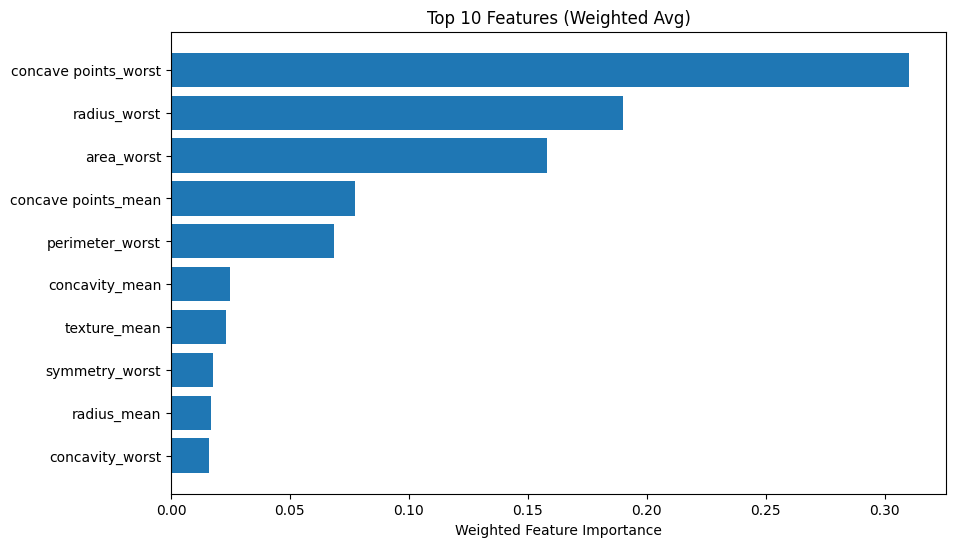

In [9]:
top_n = 10
indices = np.argsort(weighted_importance)[-top_n:]

plt.figure(figsize=(10, 6))
plt.barh(range(top_n), weighted_importance[indices], align='center')
plt.yticks(range(top_n), [feature_names[i] for i in indices])
plt.xlabel('Weighted Feature Importance')
plt.title('Top 10 Features (Weighted Avg)')
plt.show()

In [10]:
# Number of top features to keep
top_k = 10

# Get indices of top features based on weighted importance
top_indices = np.argsort(weighted_importance)[-top_k:]

# Get their names
selected_features = [feature_names[i] for i in top_indices]

print("Selected top features:", selected_features)

Selected top features: ['concavity_worst', 'radius_mean', 'symmetry_worst', 'texture_mean', 'concavity_mean', 'perimeter_worst', 'concave points_mean', 'area_worst', 'radius_worst', 'concave points_worst']


#### Training New Trees with Only Top Features

In [11]:
# Keep only selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Train new trees using only selected (shortlisted) features
trees_selected = []

for i in range(10):
    # Bootstrap sample the training data
    indices = np.random.choice(len(X_train_selected), size=len(X_train_selected), replace=True)
    X_sample = X_train_selected.iloc[indices]
    y_sample = y_train.iloc[indices]

    # Train the decision tree with random feature selection at each node
    clf = DecisionTreeClassifier(max_features='sqrt', random_state=i)
    clf.fit(X_sample, y_sample)
    trees_selected.append(clf)

#### Get Tree Predictions on Train Data
We’ll generate 10 new columns (tree_1, ..., tree_10) from the previous 10 trees’ predictions:

In [12]:
# Collect predictions of each tree on the training data
tree_outputs_train = []

for tree in trees_selected:
    preds = tree.predict(X_train_selected)
    tree_outputs_train.append(preds)

# Convert list of arrays to a DataFrame (transpose to make columns)
tree_outputs_train = np.array(tree_outputs_train).T
tree_output_df_train = pd.DataFrame(tree_outputs_train, columns=[f"tree_{i+1}" for i in range(10)])

#### Concatenate with Shortlisted Features

In [13]:
# Concatenate tree outputs with selected original features
X_meta_train = pd.concat([X_train_selected.reset_index(drop=True), tree_output_df_train], axis=1)

#### Repeat for Test Data

In [14]:
tree_outputs_test = []

for tree in trees_selected:
    preds = tree.predict(X_test_selected)
    tree_outputs_test.append(preds)

tree_outputs_test = np.array(tree_outputs_test).T
tree_output_df_test = pd.DataFrame(tree_outputs_test, columns=[f"tree_{i+1}" for i in range(10)])

X_meta_test = pd.concat([X_test_selected.reset_index(drop=True), tree_output_df_test], axis=1)

#### Train Logistic Regression Model

In [15]:
# Logistic Regression with class weight 'balanced'
log_model = LogisticRegression(max_iter=1000, class_weight='balanced')
log_model.fit(X_meta_train, y_train)

y_pred_log = log_model.predict(X_meta_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))

Logistic Regression Accuracy: 0.9316239316239316


#### Train Master Decision Tree

In [ ]:
# Master Decision Tree with class weight 'balanced'
master_tree = DecisionTreeClassifier(max_features='sqrt', class_weight='balanced', random_state=42, max_depth=5)
master_tree = DecisionTreeClassifier(max_features='log2', class_weight='balanced', random_state=42, max_depth=5)
master_tree = DecisionTreeClassifier(max_features='sqrt', class_weight='balanced', random_state=42, max_depth=2)
master_tree = DecisionTreeClassifier(max_features='log2', class_weight='balanced', random_state=42, max_depth=2)
# master_tree = DecisionTreeClassifier(class_weight='balanced', random_state=42, max_depth=2)
master_tree.fit(X_meta_train, y_train)

y_pred_master = master_tree.predict(X_meta_test)
print("Master Decision Tree Accuracy:", accuracy_score(y_test, y_pred_master))

Master Decision Tree Accuracy: 0.9017094017094017


#### Evaluating Meta-Models and Base Decision Trees on Test Data

In [ ]:
# Retain the shortlisted features from test set
X_test_selected = X_test[selected_features]

tree_preds_test = []

for tree in trees_selected:
    preds = tree.predict(X_test_selected)
    tree_preds_test.append(preds)

tree_preds_test = np.array(tree_preds_test).T
tree_output_df_test = pd.DataFrame(tree_preds_test, columns=[f'tree_{i+1}' for i in range(10)])

# Combine tree outputs with shortlisted features for meta-models
X_meta_test = pd.concat([X_test_selected.reset_index(drop=True), tree_output_df_test], axis=1)

# Predict using logistic regression model
log_pred = log_model.predict(X_meta_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, log_pred))
print("Logistic Regression Recall:", recall_score(y_test, log_pred))
print(classification_report(y_test, log_pred))

# Predict using master decision tree model
master_pred = master_tree.predict(X_meta_test)
print("Master Decision Tree Accuracy:", accuracy_score(y_test, master_pred))
print("Master Decision Tree Recall:", recall_score(y_test, master_pred))
print(classification_report(y_test, master_pred))

# Evaluate baseline accuracy from individual trees
tree_accuracies = [accuracy_score(y_test, tree_output_df_test[f'tree_{i+1}']) for i in range(10)]
avg_tree_accuracy = sum(tree_accuracies) / 10
print(f"Average Accuracy of 10 Decision Trees: {avg_tree_accuracy:.4f}")

Logistic Regression Accuracy: 0.9444444444444444
Logistic Regression Recall: 0.9263803680981595
              precision    recall  f1-score   support

           0       0.85      0.99      0.92        71
           1       0.99      0.93      0.96       163

    accuracy                           0.94       234
   macro avg       0.92      0.96      0.94       234
weighted avg       0.95      0.94      0.95       234

Master Decision Tree Accuracy: 0.9102564102564102
Master Decision Tree Recall: {0.8834355828220859}
              precision    recall  f1-score   support

           0       0.78      0.97      0.87        71
           1       0.99      0.88      0.93       163

    accuracy                           0.91       234
   macro avg       0.89      0.93      0.90       234
weighted avg       0.92      0.91      0.91       234

Average Accuracy of 10 Decision Trees: 0.9077


#### Observations
- The Logistic Regression model performed better than the Master Decision Tree.
- Logistic regression is good when we care about detecting minority class (M cases) correctly.
- Master decision tree is good but slightly weaker in identifying all malignant cases.
- Overall, this meta-model structure (feature bagging + decision tree predictions + logistic model) helps tackle the skewed dataset more effectively.
- These steps show that building smarter models using previous model outputs can give better and more reliable results.
- This is especially useful in real-world scenarios where data is often imbalanced and complex.